
# Linear Regression
**Assumptions**

1. Linearity: The relationship between X and the mean of Y is linear.
2. Homoscedasticity: The variance of residual is the same for any value of X.
3. Independence: Observations are independent of each other.
4. Normality: For any fixed value of X, Y is normally distributed.


**Ref:**
1. [Math Differential Calculus](https://colab.research.google.com/github/ageron/handson-ml2/blob/master/math_differential_calculus.ipynb#scrollTo=nwzF_EXtqqe1)

2. [Hands-On Machine Learning](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1098125975/ref=asc_df_1098125975/?tag=hyprod-20&linkCode=df0&hvadid=564681728094&hvpos=&hvnetw=g&hvrand=12536021134787862812&hvpone=&hvptwo=&hvqmt=&hvdev=c&hvdvcmdl=&hvlocint=&hvlocphy=9061321&hvtargid=pla-1651497364252&psc=1&mcid=ee20b34166b93f94b9a88a727e2204b3&gclid=CjwKCAjwt-OwBhBnEiwAgwzrUvy6fyRVoCj9LZC1E4kgyL5KvZKoFNJFSWa2nRThyPByYb_YQCTPERoCVQsQAvD_BwE)


<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/sachinprasadhs/AI-Concepts/blob/master/Common%20Concepts/Linear%20Regression/linear_regression_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

## Import Necessary Libraries

In [1]:
import jax
import numpy as np
import jax.numpy as jnp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as skm

## Generate Random Dataset

In [2]:
seed = 32
num_samples = 100000
num_features = 5


key = jax.random.PRNGKey(seed=seed)

In [3]:
random_coeff = jax.random.randint(key, shape=[num_features], minval=-10, maxval=10)

X = 2 * jax.random.normal(key, shape=(num_samples, num_features))

# Generate Random Bias and Coefficients
random_bais = jax.random.choice(key, random_coeff, shape=(1,))
random_coeff = jax.random.choice(key, random_coeff, shape=(num_features,))

print(f"Random Bias: {random_bais}")
print(f"Random Coefficients: {random_coeff}")

coeff_features = []

# Construct each feature with random coeffcients choosen
for idx, coeff in enumerate(random_coeff):
  coeff_features.append(coeff * X[:, idx:idx+1])

# Print equation
equation = f"Y = {random_bais[0]}"
for idx, coeff in enumerate(random_coeff):
  equation += f" + {coeff} * X{idx+1}"
print(equation)


# Stack the features into a single matrix
coeff_features = jnp.hstack(coeff_features)

# Generate output from random data
y = random_bais + jnp.sum(coeff_features, axis=1) + jax.random.normal(key, shape=(num_samples,))

Random Bias: [-8]
Random Coefficients: [ 8 -8 -3 -3  8]
Y = -8 + 8 * X1 + -8 * X2 + -3 * X3 + -3 * X4 + 8 * X5


## Normal Equation

$$\theta = (X^TX)^{-1} X^Ty$$

* The Normal Equation computes the inverse of $X^T X$, which is an $(n + 1) × (n + 1)$
matrix (where n is the number of features). The computational complexity of inverting
such a matrix is typically about $O(n^{2.4})$ to $O(n^3)$ (depending on the implementation).
In other words, if you double the number of features, you multiply the computation
time by roughly 22.4 = 5.3 to 23 = 8

* $X^TX$ is always guaranteed to be symmetric and positive semi-definite (non-negative eigenvalues), but that doesn't necessarily mean it's invertible.
  * **Linear Depedence:** $X^TX$ not being invertible implies the columns (or rows, since it's symmetric) of the original matrix X are linearly dependent. This means one column can be recreated by a linear combination of other columns. Imagine X has redundant information.
  * **Non-Unique Solutions:**  In contexts like linear regression where X^TX is used to find a best-fit line, non-invertibility indicates there isn't a single unique solution for the unknown variables. There might be multiple lines that fit the data about equally well.
  * **Rank and Interpretation:** The rank of X, which is essentially the number of linearly independent columns (or rows), is less than the total number of columns (or rows) if $X^TX$ is not invertible. This can point to issues with the data or model being used.

* Even when $X^TX$ is not invertible, alternative methods like the Moore-Penrose pseudoinverse can be used to find solutions, although they might not be unique.

* Both the Normal Equation and the SVD approach get very slow
when the number of features grows large (e.g., 100,000). On the
positive side, both are linear with regards to the number of instances
in the training set (they are O(m)), so they handle large training
sets efficiently, provided they can fit in memory.



In [4]:
class NormFit:
  """
  A class for fitting and predicting using the normal equation.

  Attributes:
      theta (numpy.ndarray): The parameters of the linear regression model.
  """

  def __init__(self):
    """
    Initialize the NormFit class with theta set to None.
    """
    self.theta = None

  def fit(self, X: jnp.ndarray, y: jnp.ndarray)-> jnp.ndarray:
    """
    Fit the linear regression model using the normal equation.

    Args:
        X (numpy.ndarray): The input features.
        y (numpy.ndarray): The target values.

    Returns:
        numpy.ndarray: The learned parameters (theta).
    """
    X_b = jnp.hstack((jnp.ones((X.shape[0], 1)), X))  # Add a column of ones for the bias term
    self.theta = jnp.linalg.pinv(X_b).dot(y)  # Use np.linalg.pinv instead of np.linalg.inv for better numerical stability
    return self.theta

  def predict(self, X: jnp.ndarray)-> jnp.ndarray:
    """
    Predict the target values using the learned model.

    Args:
        X (numpy.ndarray): The input features.

    Returns:
        numpy.ndarray: The predicted target values.
    """
    return X.dot(self.theta)  # Corrected: Use self.theta instead of theta

### Fit Normal Equation to Data to get Weights/Coefficients

In [5]:
normfit = NormFit()
theta = normfit.fit(X, y)

predicted_eq = f"Y_ = {jnp.round(theta[0], 1)}"
for idx, coeff in enumerate(theta[1:]):
  predicted_eq += f" + {jnp.round(coeff, 1)} * X{idx+1}"

print(predicted_eq)

Y_ = -8.0 + 8.0 * X1 + -8.0 * X2 + -3.0 * X3 + -3.0 * X4 + 8.0 * X5


## Gradient Descent Training


* Gradient Descent is a very generic optimization algorithm capable of finding optimal solutions to a wide range of problems. The general idea of Gradient Descent is to tweak parameters iteratively in order to minimize a cost function.
* Suppose you are lost in the mountains in a dense fog; you can only feel the slope of the ground below your feet. A good strategy to get to the bottom of the valley quickly is to go downhill in the direction of the steepest slope.
* This is exactly what Gradient Descent does: **it measures the local gradient of the error function with regards to the parameter vector θ, and it goes in the direction of descending gradient. Once the gradient is zero, you have reached a minimum!**
* An important parameter in Gradient Descent is the size of the steps, determined by the `learning rate` hyperparameter.
  * If the learning rate is too small, then the algorithm will have to go through many iterations to converge, which will take a long time.
  * On the other hand, if the learning rate is too high, you might jump across the valley and end up on the other side, possibly even higher up than you were before. This might make the algorithm diverge, with larger and larger values, failing to find a good solution


## Linear Regression Gradient Descent:

$$ MSE(\theta) = \dfrac{1}{m} * \sum_{i=1}^{m} (\theta^T x^{(i)} - y^{i})^{2}$$
\
$$ \dfrac{\partial}{\partial \theta_j}MSE(\theta) = \dfrac{2}{m} * \sum_{i=1}^{m} (\theta^Tx^{(i)} - y^{(i)}) \, \, x_{j}^{(i)}$$
\
$$ \nabla_\theta MSE(\theta) = \left\{ \begin{array}{c}
\frac{\partial}{\partial \theta_0} \text{MSE}(\theta) \\
\frac{\partial}{\partial \theta_1} \text{ MSE}(\theta) \\
\vdots \\
\frac{\partial}{\partial \theta_n} \text{MSE}(\theta)
\end{array} \right\} = \dfrac{2}{m}X^{T}(X\theta - y)$$

$$ \theta^{(next \, step)} = \theta - 𝞰\nabla_\theta MSE(\theta) $$

In [6]:
(1000 // 32)  * 32

992

In [7]:
class LinearRegression:
  """
  Linear Regression model implementation using JAX.

  Attributes:
      key (jnp.ndarray): Random key for weight initialization.
      lr (float): Learning rate for gradient descent.
      epochs (int): Number of training epochs.
      W (jnp.ndarray): Weights of the linear regression model.
  """

  def __init__(
      self,
      key: jnp.ndarray,
      batch_size: int = 32,
      lr: float = 0.01,
      epochs: int = 1000):
    self.key = key
    self.init_lr = lr
    self.epochs = epochs
    self.batch_size = batch_size
    self.W: jnp.ndarray = None
    self.decay = 0.001
    self.scheduler_progress = []
    self.loss_progress = []

  def learning_schedule(self, steps):
    curr_lr = self.init_lr / (1. + self.decay * steps)
    self.scheduler_progress.append(curr_lr)
    return curr_lr


  def fit(self, X: jnp.ndarray, y: jnp.ndarray) -> None:
    """
    Fit the linear regression model to the training data.

    Args:
        X (jnp.ndarray): Input features of shape (num_samples, num_features).
        y (jnp.ndarray): Target values of shape (num_samples,) or (num_samples, 1).
    """
    num_samples = X.shape[0]
    num_features = X.shape[1]
    self.W = jax.random.normal(self.key, shape=(num_features + 1, 1))  # (num_features + bias term, 1)
    X = jnp.hstack((jnp.ones(shape=(num_samples, 1)), X))  # (add column for bias term which will be one)
    y = y.reshape(-1, 1)  # Ensure y has shape (num_samples, 1)

    batch_comp = (num_samples // self.batch_size) * self.batch_size


    if num_samples != batch_comp:
      X_main, y_main = X[:batch_comp], y[:batch_comp]
      X_rem, y_rem = X[batch_comp:], y[batch_comp:]
    else:
      X_main, y_main = X, y
      X_rem, y_rem = None, None

    X_batched = X_main.reshape(num_samples// self.batch_size, self.batch_size, -1)
    y_batched = y_main.reshape(num_samples// self.batch_size, self.batch_size, -1)


    for epoch in range(self.epochs):
      epoch_loss = []
      for step, (X_batch, y_batch) in enumerate(zip(X_batched, y_batched)):
        # Forward Pass
        y_pred = X_batch @ self.W  # (num_samples, num_features + 1) @ (num_features + 1, 1) -> (num_samples, 1)

        # Calculate Gradient
        dW = (2 / self.batch_size) * (X_batch.T @ (y_pred - y_batch))  # (num_features + 1, num_samples) @ (num_samples, 1) -> (num_features + 1, 1)

        # For each batch now we calculate learning schedule using a scheduler
        # we decay with batch consider 0.1 * (1 / (1 + 0.001 * num_steps))
        num_steps = (num_samples// self.batch_size) * epoch + step
        self.lr = self.learning_schedule(num_steps)

        # Update Weights
        self.W -= self.lr * dW

        # Append Batch Loss
        epoch_loss.append((1/self.batch_size) * jnp.sum((y_pred - y_batch) ** 2))

      # Now we have to update the weights also for last batch of data which was
      # not catered when batching the data because of the data size not divisible
      # by the batch size
      if X_rem is not None:
         y_pred = X_rem @ self.W
         dW =  (2 / X_rem.shape[0]) * (X_rem.T @ (y_pred - y_rem))
         num_steps =  (num_samples// self.batch_size) * epoch + step + X_rem.shape[0]
         self.lr = self.learning_schedule(num_steps)

         # Update Weights
         self.W -= self.lr * dW
         epoch_loss.append((1/X_rem.shape[0]) * jnp.sum((y_pred - y_rem) ** 2))

      # Calculate Average Loss after each epoch
      loss = np.mean(epoch_loss)
      self.loss_progress.append(loss)
      print(f"Epoch {epoch + 1}: Loss {loss}")

  def predict(self, X: jnp.ndarray) -> jnp.ndarray:
    """
    Predict the target values for the given input features.

    Args:
        X (jnp.ndarray): Input features of shape (num_samples, num_features).

    Returns:
        jnp.ndarray: Predicted target values of shape (num_samples, 1).
    """
    X = jnp.hstack((jnp.ones(shape=(X.shape[0], 1)), X))  # Add bias term
    return X @ self.W

### Fit the Dataset using Linear Regression

In [8]:
lr = LinearRegression(key, lr=0.1, batch_size=32, epochs=5)

In [9]:
lr.fit(X, y)

Epoch 1: Loss 1.5984718799591064
Epoch 2: Loss 1.0109484195709229
Epoch 3: Loss 1.0058925151824951
Epoch 4: Loss 1.0036793947219849
Epoch 5: Loss 1.0024328231811523


### Let's plot the Learning Rate Schedule

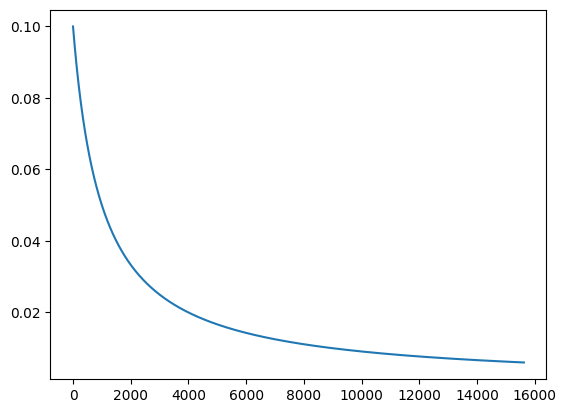

In [10]:
sns.lineplot(lr.scheduler_progress)
plt.show()

### Plot the loss

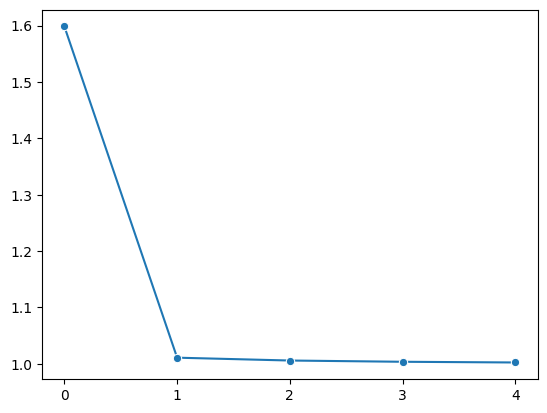

In [11]:
sns.lineplot(lr.loss_progress, marker='o')
plt.xticks([i for i in range(5)])
plt.show()

### Check the coefficients

In [12]:
predicted_eq = f"Y_ = {jnp.round(lr.W[0, 0], 1)}"
for idx, coeff in enumerate(lr.W[1:, 0]):
  predicted_eq += f" + {jnp.round(coeff, 1)} * X{idx+1}"

print(predicted_eq)

Y_ = -8.0 + 8.0 * X1 + -8.0 * X2 + -3.0 * X3 + -3.0 * X4 + 8.0 * X5


## Convex Functions

* In mathematics, a real-valued function is called convex if the line segment between any two distinct points on the graph of the function lies above the graph between the two points.

* Let $X$ be convex subset of real vector space and let $f: X → ℝ$

* Then $f$ is called convex if and only if any of the following equivalent conditions hold:
  * For all $0 \leq t \leq 1$ and $x_1, x_2 \, 𝜖 \, X$
  $$ f(tx_1 + (1-t)x_2) \leq tf(x_1) + (1-t)f(x_2)$$

* Properties of Convex funtcion:
  * Any local minima is global minima.
  * Where it exists, the hessian(second partial derivate) is positive semi-definite.
  * Sum of two convex function is a convex function.
  * max of two convex functions is a convex function.
  

## California House Price Prediction

In [13]:
df = pd.read_csv("./sample_data/california_housing_train.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


### Check for null values

In [14]:
df.isna().sum(axis=0)

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64

## Let's plot latitude and longitude with house median values

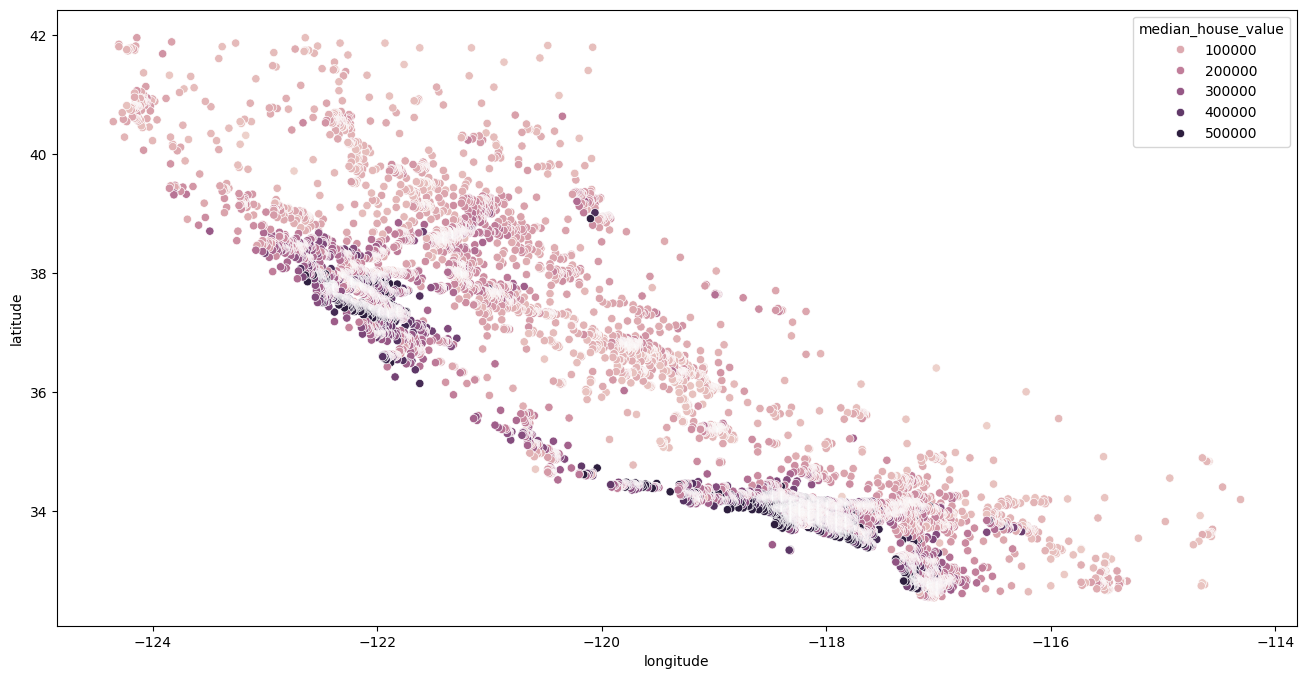

In [15]:
plt.figure(figsize=(16, 8))
sns.scatterplot(x=df['longitude'], y=df['latitude'], hue=df['median_house_value'])
plt.show()

### Let's look at the correlation matrix

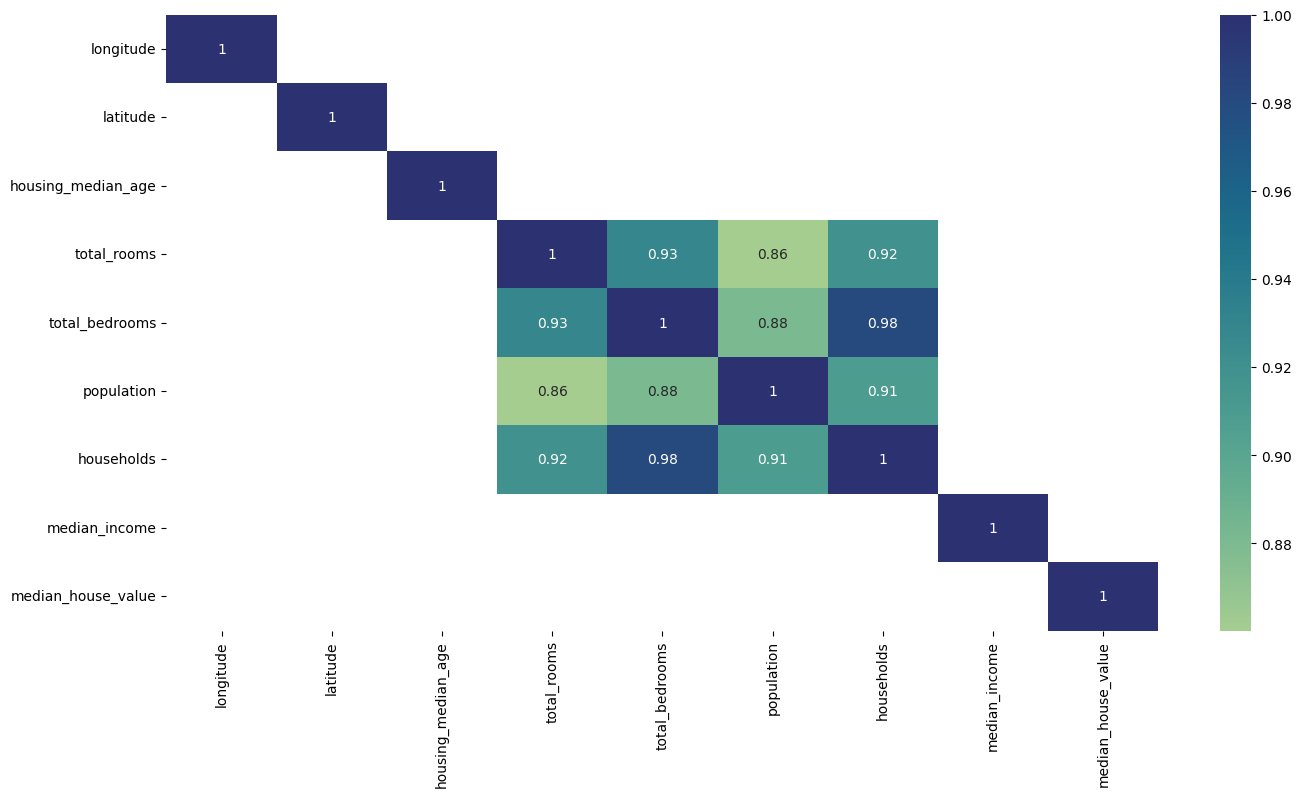

In [16]:
plt.figure(figsize=(16, 8))
sns.heatmap(df.corr()[df.corr() >= 0.7], annot=True, cmap="crest")
plt.show()

### Get feature and target columns

In [17]:
feature_columns = list(df.drop('median_house_value', axis=1).columns)
target_column = ["median_house_value"]

### Let's split the data to train and validation

In [18]:
train_df, val_df, train_y, val_y = train_test_split(
    df.drop('median_house_value', axis=1),
    df['median_house_value'],
    random_state=42)

### Pipelines for features and target separately

In [19]:
features_scaling_pipe = Pipeline(
     steps=[
         ('Standardization', StandardScaler())
     ]
)

target_scaling_pipe = Pipeline(
     steps=[
         ('Standardization', StandardScaler())
     ]
)

### Standardize the data

* Here to observe is that never fit_transform with validation data which will be lekage of the data.

In [20]:
X_train = features_scaling_pipe.fit_transform(train_df)
y_train = target_scaling_pipe.fit_transform(train_y.values.reshape(-1, 1))

### Train the model using Linear Regression

In [21]:
lr = LinearRegression(key, lr=0.1, epochs=10, batch_size=16)

lr.fit(X_train, y_train)

Epoch 1: Loss 0.4896337389945984
Epoch 2: Loss 0.3956643342971802
Epoch 3: Loss 0.3853907883167267
Epoch 4: Loss 0.38061457872390747
Epoch 5: Loss 0.3778199851512909
Epoch 6: Loss 0.3759520649909973
Epoch 7: Loss 0.37459197640419006
Epoch 8: Loss 0.37354376912117004
Epoch 9: Loss 0.3727037012577057
Epoch 10: Loss 0.37201130390167236


In [22]:
X_train.shape[0] // 16

796

### Look how Learning Rate change happened

* Here Number of Training Samples are `12750`.
* Perfect fit if batched using `16` batch size is `12750 // 16` which will be `796` steps in each epoch + `1` epoch for remaining samples left after batching.
* So now we have `(796 + 1) * 10` epoch it will `7970` exact points of learning rates.
* For each batch the learning rate is decayed as per the learning rate schedule
$$ lr = lr_{initial} * \dfrac{1}{1 + decay * steps}$$

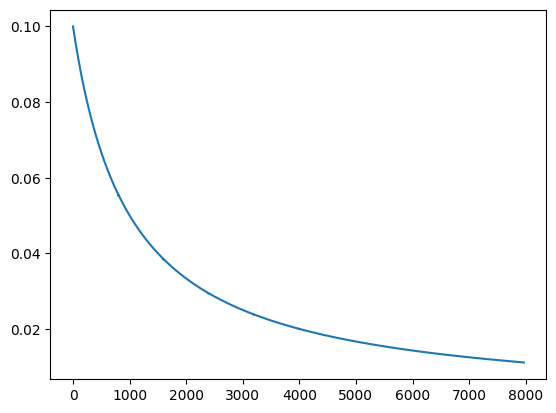

In [23]:
sns.lineplot(lr.scheduler_progress)
plt.show()

### Plot the loss for each epoch

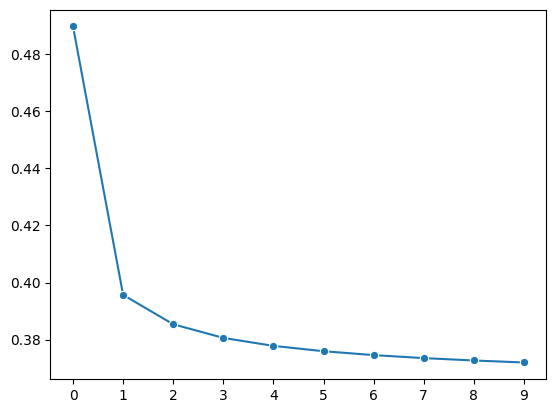

In [24]:
sns.lineplot(lr.loss_progress, marker='o')
plt.xticks([i for i in range(10)])
plt.show()

### Let's validate the model

In [25]:
X_val = features_scaling_pipe.transform(val_df)
y_val = target_scaling_pipe.transform(val_y.values.reshape(-1, 1))

In [26]:
y_val = target_scaling_pipe.inverse_transform(y_val.reshape(-1, 1))
y_pred = target_scaling_pipe.inverse_transform(lr.predict(X_val))

### Check RMSE
$$ MSE = \dfrac{1}{m} \sum_{i=1}^{m} (y^{i}_{pred} - y_{i})^{2} $$
* As MSE will be very high due to high values of the house prices

In [27]:
print(f"Root Mean Squared Error:{skm.mean_squared_error(y_val, y_pred, squared=False)}")

Root Mean Squared Error:69350.5147344283


### Let's plot upto 50 predictions using seaborn

In [28]:
idxs = val_df.reset_index(drop=True).index

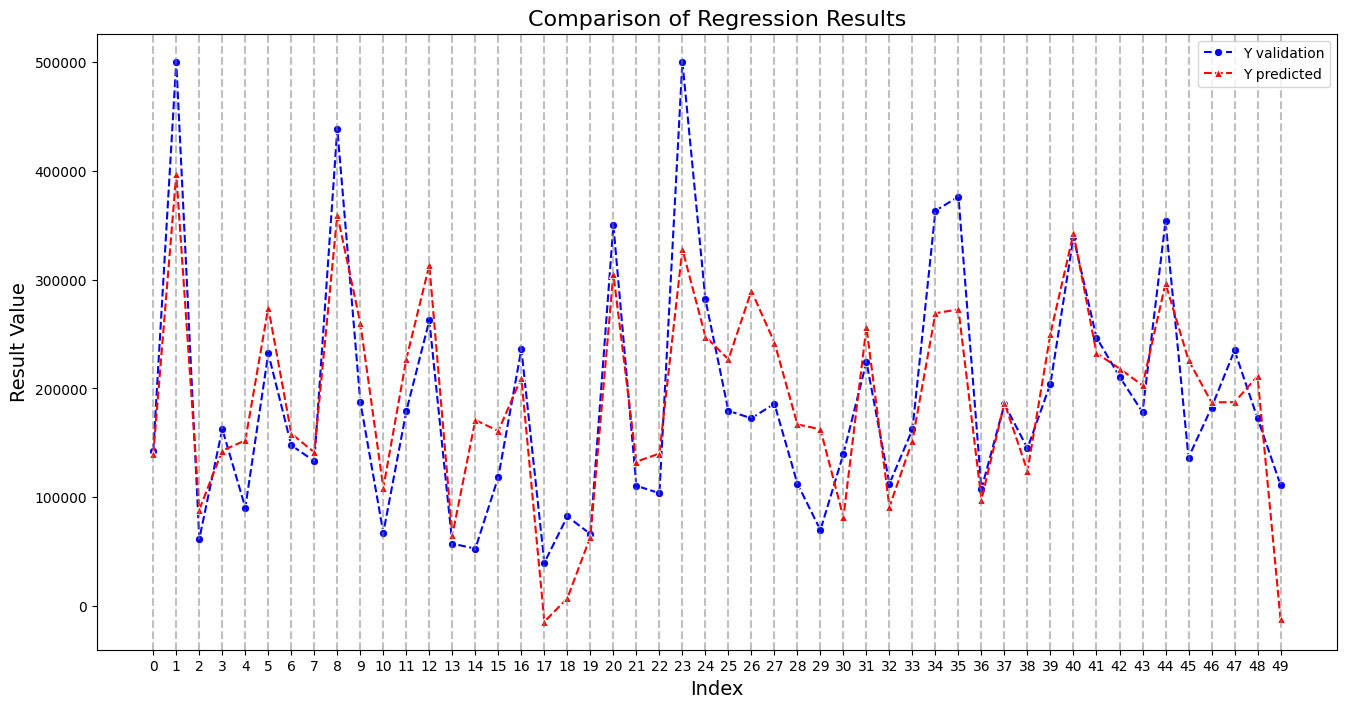

In [29]:
points = 50

plt.figure(figsize=(16, 8))
ax = sns.lineplot(x=idxs[:points],
                  y=y_val.reshape(-1)[:points],
                  color='b',
                  marker='o',
                  label='Y validation',
                  linestyle='--')
sns.lineplot(x=idxs[:points],
             y=y_pred.reshape(-1)[:points],
             color='r',
             marker='^',
             label='Y predicted',
             linestyle='--')


# Add vertical and horizontal lines
for idx in idxs[:points]:
  ax.axvline(idx, color='gray', linestyle='--', alpha=0.5)


# Add gridlines at each index
ax.set_xticks(idxs[:points])

# Add labels and title
plt.xlabel('Index', fontsize=14)
plt.ylabel('Result Value', fontsize=14)
plt.title('Comparison of Regression Results', fontsize=16)

# Add legend
plt.legend()

plt.show()

## $R$ Squared

* An R-Squared value shows how well the model predicts the outcome of the dependent variable. R-Squared values range from 0 to 1.
* An R-Squared value of 0 means that the model explains or predicts 0% of the relationship between the dependent and independent variables.

In [30]:
print(f"{skm.r2_score(y_val, y_pred)*100}% of the variance in the dependent variable can be explained by the independent variable(s)")

64.96508450769805% of the variance in the dependent variable can be explained by the independent variable(s)
